## Random

In [2]:
!pip install pandas tqdm scipy matplotlib torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 7.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.6/199.6 KB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 7.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 31.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 12.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 23.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 16.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 10.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━

In [5]:
pip install omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 2.4 MB/s eta 0:00:00
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
%autreload 2

UsageError: Line magic function `%autreload` not found.


In [3]:
import torch

ckpt_path = "/root/.boltz/boltz2_conf.ckpt"

checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

print("Top-level keys:")
print(checkpoint.keys())

# Explore model state dict keys
print("\nState dict keys (truncated):")
for k in list(checkpoint['state_dict'].keys())[:20]:  # Show first 20 keys
    print(k)

# If hyperparameters were saved
if 'hyper_parameters' in checkpoint:
    print("\nHyperparameters:")
    for k, v in checkpoint['hyper_parameters'].items():
        print(f"{k}: {v}")


Top-level keys:
dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

State dict keys (truncated):
input_embedder.atom_encoder.embed_atom_features.weight
input_embedder.atom_encoder.embed_atom_features.bias
input_embedder.atom_encoder.embed_atompair_ref_pos.weight
input_embedder.atom_encoder.embed_atompair_ref_dist.weight
input_embedder.atom_encoder.embed_atompair_mask.weight
input_embedder.atom_encoder.c_to_p_trans_k.1.weight
input_embedder.atom_encoder.c_to_p_trans_q.1.weight
input_embedder.atom_encoder.p_mlp.1.weight
input_embedder.atom_encoder.p_mlp.3.weight
input_embedder.atom_encoder.p_mlp.5.weight
input_embedder.atom_enc_proj_z.0.weight
input_embedder.atom_enc_proj_z.0.bias
input_embedder.atom_enc_proj_z.1.weight
input_embedder.atom_attention_encoder.atom_encoder.diffusion_transformer.layers.0.adaln.s_norm.weight
input_embedder.atom_attention_encoder.atom_enco

In [4]:
import sys
sys.path.append("/workspace/gfp_function_prediction")
sys.path.append("/workspace/gfp_function_prediction/boltz")

In [6]:
import sys
import os

# Add the parent directory to sys.path to import boltz
sys.path.append(os.path.join(os.getcwd(), '..'))

try:
    from src.boltz.model.models.boltz2 import Boltz2
    print("✅ Successfully imported Boltz2!")
except ImportError as e:
    print(f"❌ Failed to import Boltz2: {e}")
    print(f"Current sys.path: {sys.path}")

✅ Successfully imported Boltz2!


In [1]:
from pathlib import Path
from dataclasses import asdict, dataclass

In [9]:
from boltz.main import BoltzSteeringParams, Boltz2DiffusionParams, PairformerArgsV2, MSAModuleArgs
from boltz.model.models.boltz2 import Boltz2

In [17]:
from collections import defaultdict

class PairformerHookCollector:
    def __init__(self):
        self.hidden_reps = defaultdict(list)
        self.hooks = []

    def register_hooks(self, model):
        pairformer = (
            model.pairformer_module._orig_mod
            if getattr(model, "is_pairformer_compiled", False)
            else model.pairformer_module
        )

        def hook_fn(module, inputs, outputs):
            try:
                s, z = outputs
                self.hidden_reps["s"].append(s.detach().cpu())
                self.hidden_reps["z"].append(z.detach().cpu())
                print(f"[HOOK FIRED] s: {s.shape}, z: {z.shape}")
            except Exception as e:
                print(f"[HOOK ERROR] {e}")

        self.hooks.append(pairformer.register_forward_hook(hook_fn))

    def get(self):
        return dict(self.hidden_reps)

    def clear(self):
        self.hidden_reps.clear()

    def remove(self):
        for h in self.hooks:
            h.remove()


## Analysis Effective Strain 

Possible sanity check is to check that the files of these mutations are concording with the extracted one here for the analyssi

In [1]:
import numpy as np
import pandas as pd
import os 
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
main_dir = Path("/n/home06/tbush/gfp_function_prediction/data/outputs/chunks_20250923_120550")
tsv_path = Path("/n/home06/tbush/gfp_function_prediction/data/raw_data/amino_acid_genotypes_to_brightness.tsv")

In [3]:
import re

def extract_seq_numbers(file_ids):
    """
    Extract integer sequence numbers from file_ids of the form
    '.../seq_00017.fasta_prot_pipeline_model_0_output'.

    Args:
        file_ids (list[str]): list of file identifier strings

    Returns:
        list[int]: extracted sequence numbers
    """
    seq_nums = []
    for fid in file_ids:
        match = re.search(r"seq_(\d+)", fid)
        if not match:
            raise ValueError(f"Could not find 'seq_' pattern in: {fid}")
        seq_nums.append(int(match.group(1)))
    return seq_nums

In [4]:
def load_strain_numpy_recursive(root_dir: Path, column: str = "strain"):
    """
    Recursively loads 'column' from every .csv under root_dir.

    Returns
    -------
    strain : np.ndarray, shape (n_files, n_residues)
    file_ids : list[str], relative paths without .csv (e.g., 'subdir/sample1')
    files : list[Path], absolute Paths to the files (same order as rows)
    """
    # Collect and sort all CSVs deterministically
    files = sorted((p for p in root_dir.rglob("*.csv") if p.is_file()),
                   key=lambda p: str(p.relative_to(root_dir)))
    if not files:
        raise ValueError(f"No .csv files found under {root_dir}")

    arrays = []
    lengths = []
    file_ids = []

    for f in files:
        df = pd.read_csv(f)
        if column not in df:
            raise ValueError(f"Column '{column}' not found in {f}")
        arr = df[column].to_numpy(dtype=float)
        arrays.append(arr)
        lengths.append(arr.shape[0])
        # Keep a readable identifier: relative path without extension
        file_ids.append(str(f.relative_to(root_dir).with_suffix("")))

    # Sanity check: all have same length
    if len(set(lengths)) != 1:
        raise ValueError(f"Not all files have the same number of residues: {dict(zip(file_ids, lengths))}")

    strain = np.stack(arrays, axis=0)
    return strain, file_ids, files

In [5]:
def get_numb_mut(mut: str) -> int:
    """Helper function to count number of mutations from mutation string"""
    if type(mut) == str:
        n = len(mut.split(":"))
    else:
        return 0
    return n

In [6]:
strain_t, files_id, files = load_strain_numpy_recursive(main_dir)

In [7]:
gfp_dataset = pd.read_csv(tsv_path, sep='\t')
gfp_dataset["num_mut"] = gfp_dataset["aaMutations"].apply(get_numb_mut)
seq_nums = extract_seq_numbers(files_id)
filtered_df = gfp_dataset.loc[gfp_dataset.index.isin(seq_nums)]

In [13]:
gfp_dataset.head()

,aaMutations,uniqueBarcodes,medianBrightness,std,num_mut
0,NaN,3645,3.719212,0.106992,0
1,SA108D,1,1.301030,NaN,1
2,SA108D:SN144D:SI186V:SM231T:SL234P,1,1.301031,NaN,5
3,SA108D:SY141N:SH146L:SE220G,1,1.301189,NaN,4
4,SA108G,2,3.708478,0.020613,1


### Effective strain analyssi over whole data

In [8]:
brightness = filtered_df["medianBrightness"].values

# Option 1: Vectorized with numpy.corrcoef (fast)
corrs = np.array([
    np.corrcoef(strain_t[:, i], brightness)[0, 1]
    for i in range(strain_t.shape[1])
])

In [9]:
corrs.argmin()

np.int64(190)

In [10]:
corr_df = pd.DataFrame({
    "residue": np.arange(strain_t.shape[1]),
    "correlation": corrs
})

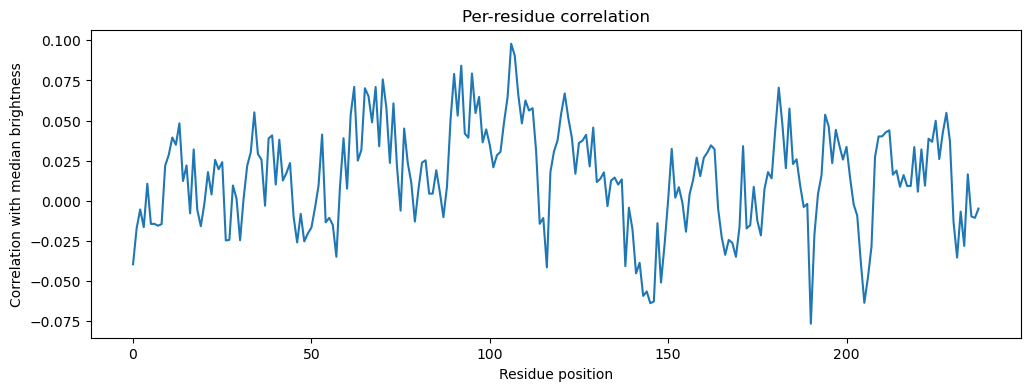

In [11]:
plt.figure(figsize=(12,4))
plt.plot(corr_df["residue"], corr_df["correlation"])
plt.xlabel("Residue position")
plt.ylabel("Correlation with median brightness")
plt.title("Per-residue correlation")
plt.show()


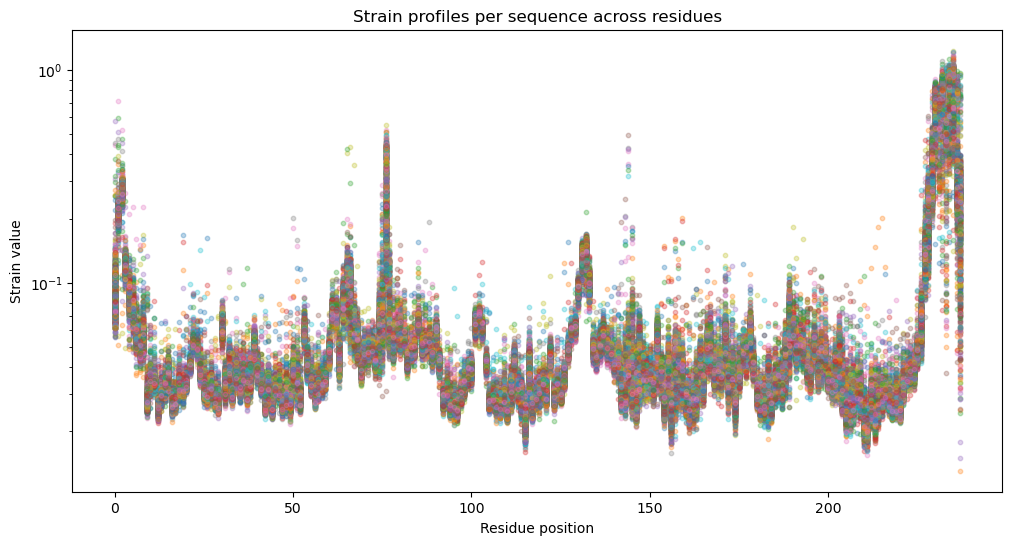

In [12]:
plt.figure(figsize=(12,6))
for i in range(strain_t.shape[0]):   # loop over sequences
    plt.scatter(range(strain_t.shape[1]), strain_t[i, :], alpha=0.3, s=10)

plt.xlabel("Residue position")
plt.ylabel("Strain value")
plt.yscale("log")
plt.title("Strain profiles per sequence across residues")
plt.show()

### Effective strain analysis over data with n number of mutations

In [43]:
gfp_dataset = pd.read_csv(tsv_path, sep='\t')
gfp_dataset["num_mut"] = gfp_dataset["aaMutations"].apply(get_numb_mut)
seq_nums = extract_seq_numbers(files_id)
filtered_df = gfp_dataset.loc[gfp_dataset.index.isin(seq_nums)]

In [55]:
len(gfp_dataset["num_mut"]==1)

54025

In [52]:
# mask = (filtered_df["num_mut"] == 1) | (filtered_df["num_mut"] == 2)
mask = filtered_df["num_mut"] == 1
idx = np.where(mask)[0]
filtered_df = filtered_df.iloc[idx]
strain_selected = strain_t[idx, :]

In [53]:
len(filtered_df)

41

In [47]:
brightness = filtered_df["medianBrightness"].values

# Option 1: Vectorized with numpy.corrcoef (fast)
corrs = np.array([
    np.corrcoef(strain_selected[:, i], brightness)[0, 1]
    for i in range(strain_selected.shape[1])
])

In [48]:
corr_df = pd.DataFrame({
    "residue": np.arange(strain_selected.shape[1]),
    "correlation": corrs
})

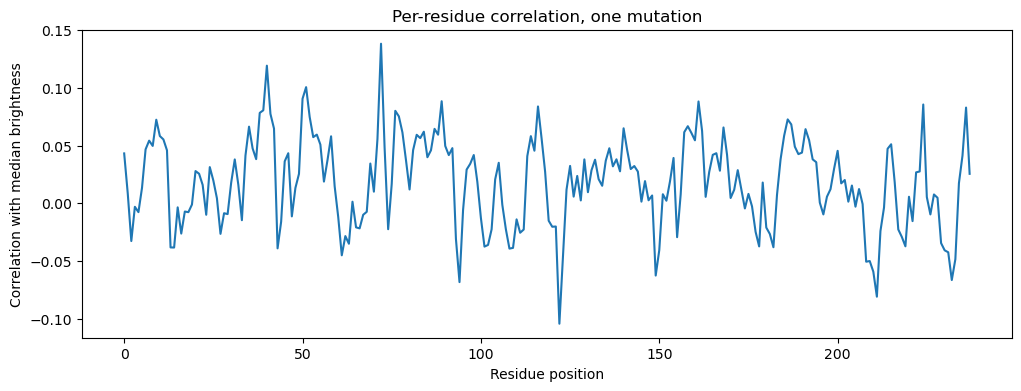

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(corr_df["residue"], corr_df["correlation"])
plt.xlabel("Residue position")
plt.ylabel("Correlation with median brightness")
plt.title("Per-residue correlation, one mutation")
plt.show()

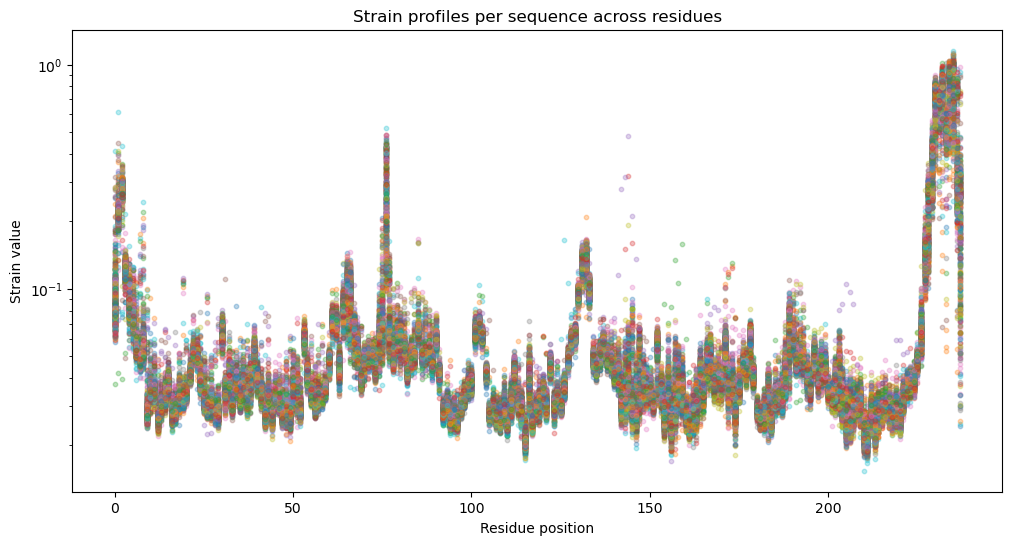

In [50]:
plt.figure(figsize=(12,6))
for i in range(strain_selected.shape[0]):   # loop over sequences
    plt.scatter(range(strain_selected.shape[1]), strain_selected[i, :], alpha=0.3, s=10)

plt.xlabel("Residue position")
plt.ylabel("Strain value")
plt.yscale("log")
plt.title("Strain profiles per sequence across residues")
plt.show()

## Extra stuff

In [13]:
import scipy

In [14]:
correlation_pos = []
for i in tqdm(range(final_array.shape[1])):
    correlation_pos.append(scipy.stats.pearsonr(final_array[:, i, 1], filtered_df['medianBrightness'].values))


100%|██████████| 238/238 [00:00<00:00, 551.74it/s]


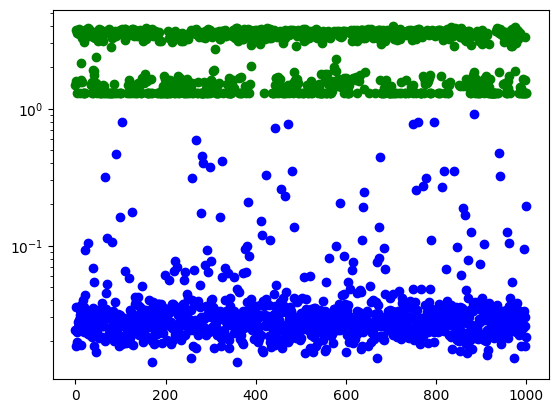

In [15]:
from turtle import color


plt.figure()
plt.scatter(y=filtered_df['medianBrightness'].values, x=np.arange(filtered_df['medianBrightness'].values.shape[0]), color='g')
plt.scatter(y=final_array[:, 57, 1], x=np.arange(final_array[:, 57, 1].shape[0]), color='b')
plt.yscale('log')
plt.show()

In [59]:
import scipy

In [62]:
scipy.stats.pearsonr(final_array[:, 57, 1], filtered_df['medianBrightness'].values)

PearsonRResult(statistic=np.float64(0.03381930920638052), pvalue=np.float64(0.28484485015629946))

In [16]:
corrs = np.stack(correlation_pos, 0)

In [17]:
np.argmax(corrs, 0)

array([74, 37])

In [21]:
final_array[:, 57, 1].argmax()

np.int64(884)

In [18]:
corrs[74]

array([0.06206207, 0.04953265])